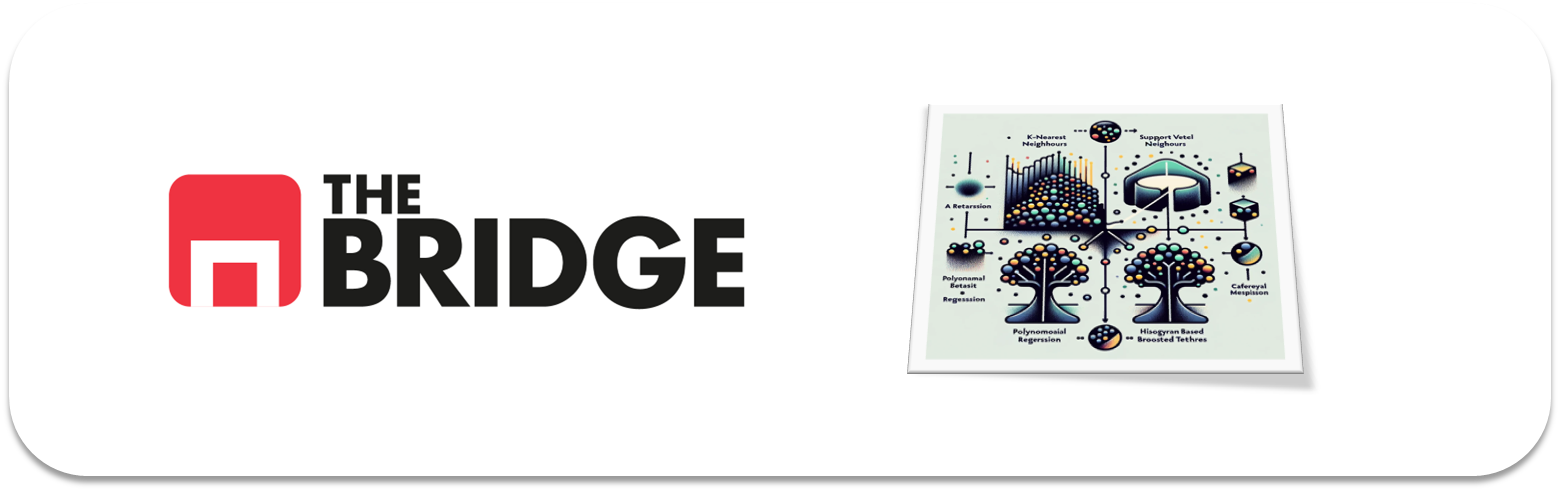

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [70]:
import bootcampviztools as bt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
from imblearn.over_sampling import SMOTE # Nuevos amigos para ayudaros
from imblearn.under_sampling import RandomUnderSampler # Nuevos amigos para ayudarnos
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df = pd.read_csv("data/credit_npo.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [4]:
def describe_df(df):
    """
    Recibe un dataframe y devuelve otro dataframe con los nombres 
    de las columnas del dataframe transferido a la función. En filas contiene 
    los parámetros descriptivos del dataframe: 
    - Tipo de dato
    - % Nulos (Porcentaje de valores nulos)
    - Valores Únicos
    - % Cardinalidad (Relación de valores únicos con el total de registros)
    
    Argumentos:
    - df (DataFrame): DataFrame de trabajo
    
    Retorna:
    - DataFrame con los parámetros descriptivos
    """
    
    summary_df = pd.DataFrame(index=['Tipo', '% Nulos', "Valores infinitos", 'Valores Únicos', '% Cardinalidad'])

    for column in df.columns:
        tipo = df[column].dtype
        porcentaje_nulos = df[column].isnull().mean() * 100
        verificar_si_es_numerico = np.issubdtype(df[column].dtype,np.number)
        if (verificar_si_es_numerico):
            valores_inf = ("Yes" if np.isinf(df[column]).any() else "No")
        else:
            valores_inf = "No"
        valores_unicos = df[column].nunique()
        cardinalidad = (valores_unicos / len(df)) * 100

        summary_df[column] = [tipo, f"{porcentaje_nulos:.2f}%",valores_inf, valores_unicos, f"{cardinalidad:.2f}%"]

    return summary_df



In [5]:
describe_df(df)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Tipo,int64,float64,int64,int64,float64,float64,int64,int64,int64,int64,float64
% Nulos,0.00%,0.00%,0.00%,0.00%,0.00%,5.75%,0.00%,0.00%,0.00%,0.00%,1.41%
Valores infinitos,No,No,No,No,No,No,No,No,No,No,No
Valores Únicos,2,10764,78,10,11547,4167,43,13,16,8,10
% Cardinalidad,0.02%,85.86%,0.62%,0.08%,92.10%,33.24%,0.34%,0.10%,0.13%,0.06%,0.08%


In [6]:
def descripcion_variables(df, umbral_categoria=10):
    """
    Muestra una descripción textual de las variables de un DataFrame,
    clasificándolas como binarias, categóricas, discretas o continuas.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        umbral_categoria (int): Número máximo de valores únicos para que una variable numérica discreta
                                sea considerada categórica.
    """
    for col in df.columns:
        print(f"\n🔹 Variable: {col}")
        tipo = df[col].dtype
        print(f"Tipo: {tipo}")

        n_unicos = df[col].nunique()
        valores_unicos = df[col].dropna().unique()

        if n_unicos == 2:
            print("Tipo inferido: Binaria")
            modo = df[col].mode().iloc[0]
            frecuencia = df[col].value_counts().iloc[0]
            print(f"Más frecuente: {modo} ({frecuencia} veces)")

        elif tipo == "object":
            print("Tipo inferido: Categórica")
            print(f"Valores únicos: {n_unicos}")
            print(f"Más frecuente: {df[col].mode().iloc[0]} ({df[col].value_counts().iloc[0]} veces)")

        elif pd.api.types.is_integer_dtype(df[col]) and n_unicos <= umbral_categoria:
            print("Tipo inferido: Discreta (recuento entero con pocos valores únicos)")
            print(f"Valores únicos: {n_unicos}")
            print(f"Más frecuente: {df[col].mode().iloc[0]} ({df[col].value_counts().iloc[0]} veces)")

        elif pd.api.types.is_numeric_dtype(df[col]):
            print("Tipo inferido: Numérica continua")
            print(f"Media: {df[col].mean():.2f}")
            print(f"Desviación estándar: {df[col].std():.2f}")
            print(f"Mínimo: {df[col].min()}")
            print(f"Máximo: {df[col].max()}")

        else:
            print("Tipo no identificado con claridad.")


In [7]:
descripcion_variables(df)


🔹 Variable: SeriousDlqin2yrs
Tipo: int64
Tipo inferido: Binaria
Más frecuente: 0 (11673 veces)

🔹 Variable: RevolvingUtilizationOfUnsecuredLines
Tipo: float64
Tipo inferido: Numérica continua
Media: 0.33
Desviación estándar: 0.37
Mínimo: 0.0
Máximo: 6.0

🔹 Variable: age
Tipo: int64
Tipo inferido: Numérica continua
Media: 52.08
Desviación estándar: 15.08
Mínimo: 21
Máximo: 101

🔹 Variable: NumberOfTime30-59DaysPastDueNotWorse
Tipo: int64
Tipo inferido: Discreta (recuento entero con pocos valores únicos)
Valores únicos: 10
Más frecuente: 0 (10500 veces)

🔹 Variable: DebtRatio
Tipo: float64
Tipo inferido: Numérica continua
Media: 1.90
Desviación estándar: 9.12
Mínimo: 0.0
Máximo: 99.0

🔹 Variable: MonthlyIncome
Tipo: float64
Tipo inferido: Numérica continua
Media: 6864.82
Desviación estándar: 11855.91
Mínimo: 0.0
Máximo: 702500.0

🔹 Variable: NumberOfOpenCreditLinesAndLoans
Tipo: int64
Tipo inferido: Numérica continua
Media: 8.48
Desviación estándar: 5.17
Mínimo: 0
Máximo: 49

🔹 Variable

## 📊 Descripción de las variables del dataset “Give Me Some Credit”

- **`SeriousDlqin2yrs`**  
  Variable **binaria** que indica si el individuo ha sufrido una morosidad grave en los dos últimos años (`0`: no, `1`: sí).  
  🔹 Valor más frecuente: `0` (11.673 casos)

- **`RevolvingUtilizationOfUnsecuredLines`**  
  Variable **numérica continua** que representa el ratio de utilización de las líneas de crédito no aseguradas.  
  🔹 Media: `0.33`  
  🔹 Desviación estándar: `0.37`  
  🔹 Máximo: `6.0` → *indica posibles outliers*

- **`age`**  
  Variable **numérica continua** que indica la edad del individuo.  
  🔹 Media: `52.08`  
  🔹 Desviación estándar: `15.08`  
  🔹 Rango: `21 – 101`

- **`NumberOfTime30-59DaysPastDueNotWorse`**  
  Variable **discreta** que indica cuántas veces se ha retrasado el pago entre 30 y 59 días.  
  🔹 Valores únicos: `10`  
  🔹 Valor más frecuente: `0` (10.500 casos)

- **`DebtRatio`**  
  Variable **numérica continua** que expresa el ratio entre deuda total mensual e ingresos brutos mensuales.  
  🔹 Media: `1.90`  
  🔹 Desviación estándar: `9.12`  
  🔹 Máximo: `99.0` → *posibles outliers*

- **`MonthlyIncome`**  
  Variable **numérica continua** que recoge el ingreso mensual.  
  🔹 Media: `6.865`  
  🔹 Desviación estándar: `11.855`  
  🔹 Máximo: `702.500` → *valor extremadamente alto*

- **`NumberOfOpenCreditLinesAndLoans`**  
  Variable **numérica continua** que indica el número de líneas de crédito y préstamos abiertos.  
  🔹 Media: `8.48`  
  🔹 Desviación estándar: `5.17`  
  🔹 Máximo: `49`

- **`NumberOfTimes90DaysLate`**  
  Variable **numérica continua** que recoge la cantidad de veces con pagos retrasados más de 90 días.  
  🔹 Media: `0.26`  
  🔹 Desviación estándar: `4.04`  
  🔹 Máximo: `98` → *recuento alto, tratada como continua*

- **`NumberRealEstateLoansOrLines`**  
  Variable **numérica continua** que representa el número de préstamos o líneas de crédito inmobiliarias.  
  🔹 Media: `1.00`  
  🔹 Desviación estándar: `1.13`  
  🔹 Máximo: `19`

- **`NumberOfTime60-89DaysPastDueNotWorse`**  
  Variable **discreta** que indica cuántas veces se ha retrasado el pago entre 60 y 89 días.  
  🔹 Valores únicos: `8`  
  🔹 Valor más frecuente: `0` (11.901 casos)

- **`NumberOfDependents`**  
  Variable **numérica continua**, aunque representa un recuento de personas a cargo.  
  🔹 Media: `0.82`  
  🔹 Desviación estándar: `1.14`  
  🔹 Máximo: `10`


In [8]:
def tipifica_variables(df, umbral_categoria=10, umbral_continua=0.2):
    """
    Clasifica las columnas de un DataFrame según su tipo de variable: Binaria, Categórica, Numérica Discreta o Continua.

    Argumentos:
    df (pd.DataFrame): DataFrame de entrada.
    umbral_categoria (int): Máximo número de valores únicos para que una variable sea considerada categórica.
    umbral_continua (float): Porcentaje mínimo (sobre total de filas) para considerar una variable como continua.

    Devuelve:
    pd.DataFrame: DataFrame con columnas 'nombre_variable' y 'tipo_sugerido'.
    """
    resultado = []
    n = len(df)

    for col in df.columns:
        cardinalidad = df[col].nunique()
        porcentaje_cardinalidad = round(cardinalidad / n, 2)

        if cardinalidad == 2:
            tipo = "Binaria"
        elif cardinalidad < umbral_categoria:
            tipo = "Categórica"
        elif porcentaje_cardinalidad >= umbral_continua:
            tipo = "Numerica Continua"
        else:
            tipo = "Numerica Discreta"

        resultado.append({
            "nombre_variable": col,
            "tipo_sugerido": tipo
        })

    return pd.DataFrame(resultado)


In [9]:
tipifica_variables(df)

,nombre_variable,tipo_sugerido
0,SeriousDlqin2yrs,Binaria
1,RevolvingUtilizationOfUnsecuredLines,Numerica Continua
2,age,Numerica Discreta
3,NumberOfTime30-59DaysPastDueNotWorse,Numerica Discreta
4,DebtRatio,Numerica Continua
5,MonthlyIncome,Numerica Continua
6,NumberOfOpenCreditLinesAndLoans,Numerica Discreta
7,NumberOfTimes90DaysLate,Numerica Discreta
8,NumberRealEstateLoansOrLines,Numerica Discreta
9,NumberOfTime60-89DaysPastDueNotWorse,Categórica


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

*Problema de clasificación binaria, para predecir si una persona va a experimentar dificultades financieras en los próximos dos años. Implica asignar a cada individuo una de dos clases posibles: si(1) o no(0).*

*La variable target es SeriousDlqin2yrs, que toma valores (1) si el individuo tuvo problemas financieros (como imapgo de deuda grave) o (0) si no los tuvo.*

In [10]:
target = "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

In [16]:
def plot_target_distribution(df, target):
    """
    Grafica la distribución de frecuencias de la variable target.

    Args:
        df (pd.DataFrame): DataFrame que contiene los datos.
        target (str): Nombre de la variable objetivo.
    """
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=target, hue=target, palette="pastel", legend=False)
    plt.title(f"Distribución de la variable objetivo: {target}")
    plt.xlabel(target)
    plt.ylabel("Frecuencia")
    total = len(df)
    
    for p in plt.gca().patches:
        height = p.get_height()
        pct = height / total * 100
        plt.text(p.get_x() + p.get_width()/2, height + 100, f'{pct:.1f}%', ha="center")

    plt.tight_layout()
    plt.show()

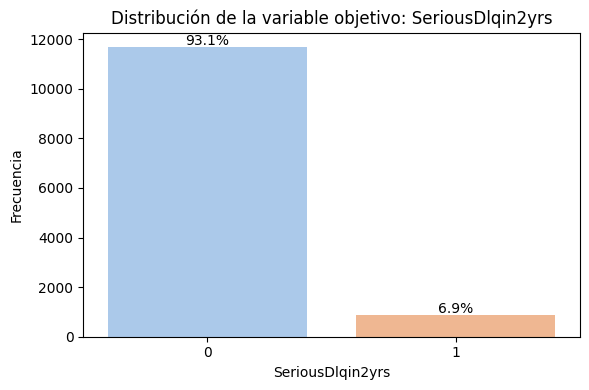

In [18]:
plot_target_distribution(df, target)

*La variable objetivo SeriousDlqin2yrs presenta una distribución muy desbalanceada, con aproximadamente un 93,1% de los registros correspondientes a la clase 0 (sin dificultades financieras) y solo un 6,9% a la clase 1 (con dificultades).*

*Este desbalance es muy común en datasets de riesgo financiero y puede afectar negativamente al rendimiento de modelos predictivos si se utiliza la métrica de accuracy sin ajustes. Será necesario tenerlo en cuenta y considerar:*

*- Uso de métricas como precisión, recall o F1-score,*
*- Técnicas como resampling (oversampling, SMOTE, undersampling),*
*- Uso de algoritmos que manejen clases desbalanceadas, como árboles con class_weight='balanced'.*

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [14]:
# Eliminación de columnas innecesarias
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

In [20]:
# Separación de columna target y resto
X = df.drop(columns=target)
y = df[target]

In [24]:
# División en conjunto de entrenamiento y prueba
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [26]:
# Identificar variables numéricas
features_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
train_set[features_num].describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,10029.000000,10029.000000,10029.00000,10029.000000,9458.000000,10029.000000,10029.000000,10029.000000,10029.000000,9889.000000
mean,0.332534,52.006681,0.40014,1.859805,6899.357158,8.480905,0.250972,0.997408,0.221258,0.819395
std,0.368161,15.064668,3.96043,9.053464,12785.807976,5.150639,3.940818,1.145652,3.923659,1.134976
min,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030773,41.000000,0.00000,0.142648,3481.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.164421,51.000000,0.00000,0.301520,5415.500000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.588571,62.000000,0.00000,0.506312,8290.750000,11.000000,0.000000,2.000000,0.000000,1.000000
max,5.347652,101.000000,98.00000,99.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


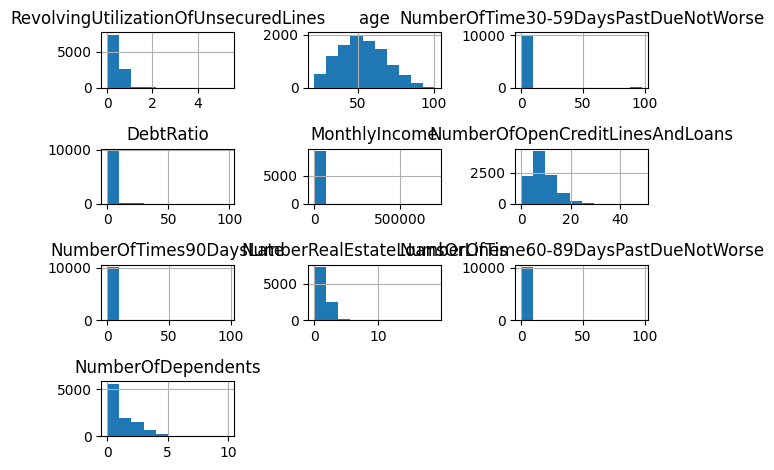

In [27]:
train_set[features_num].hist()
plt.tight_layout();

🚨 Variables con outliers muy marcados:
- RevolvingUtilizationOfUnsecuredLines → valores >1 totalmente anómalos.

- DebtRatio → mayoría en <5, pero algunos casos extremos en 90–100.

- MonthlyIncome → distribución muy sesgada, valores enormes.

- NumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse → cola larguísima por valores tipo 98.

In [35]:
from scipy.stats import pointbiserialr

def get_features_num_classification(df, target_col, umbral_corr=0.1, pvalue=None, mostrar=False):
    """
    Devuelve las variables numéricas más correlacionadas con una variable target binaria.

    Args:
        df (pd.DataFrame): DataFrame que contiene los datos.
        target_col (str): Nombre de la columna objetivo (debe ser binaria).
        umbral_corr (float): Valor mínimo absoluto de correlación para seleccionar una variable.
        pvalue (float or None): Nivel de significancia para filtrar correlaciones (si se desea).
        mostrar (bool): Si True, muestra un heatmap de correlaciones con la target.

    Returns:
        list: Lista de columnas numéricas que cumplen los criterios de selección.
    """

    if target_col not in df.columns:
        raise ValueError(f"La columna {target_col} no está en el DataFrame.")

    if df[target_col].nunique() != 2:
        raise ValueError("La variable target debe ser binaria (solo dos valores únicos).")

    if df[target_col].isnull().sum() > 0:
        raise ValueError("La variable target contiene valores nulos.")

    num_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop(target_col)
    resultados = []

    for col in num_cols:
        if df[col].isnull().sum() == 0:
            corr, p = pointbiserialr(df[target_col], df[col])
            if abs(corr) >= umbral_corr and (pvalue is None or p < pvalue):
                resultados.append((col, corr, p))
        else:
            continue  # Saltar columnas con nulos

    resultados_ordenados = sorted(resultados, key=lambda x: abs(x[1]), reverse=True)
    
    if mostrar:
        corr_map = df[[target_col] + [r[0] for r in resultados_ordenados]].corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_map, annot=True, cmap="coolwarm", center=0)
        plt.title(f"Correlaciones con {target_col}")
        plt.show()

    return [r[0] for r in resultados_ordenados]

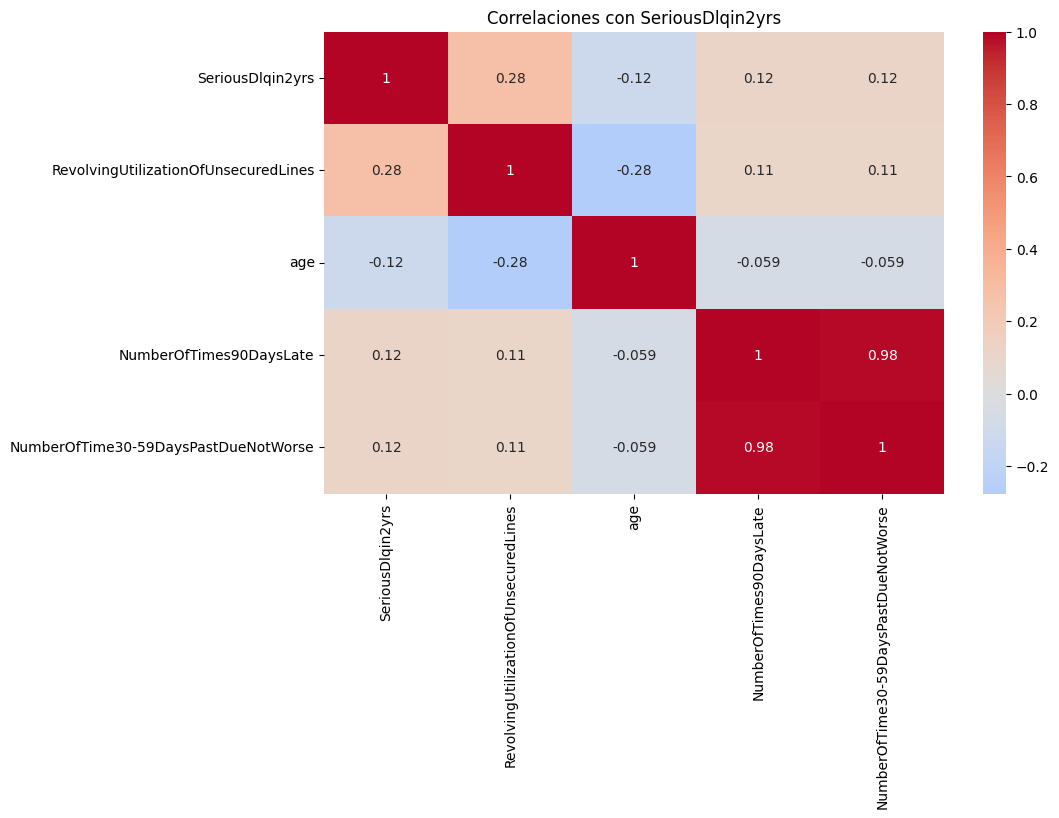

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse']


In [36]:
features_mas_relacionadas = get_features_num_classification(
    df,
    target_col="SeriousDlqin2yrs",
    umbral_corr=0.1,
    pvalue=0.05,
    mostrar=True
)

print(features_mas_relacionadas)

In [43]:
X_train = train_set.drop(columns=target)
y_train = train_set[target]

X_test = test_set.drop(columns=target)
y_test = test_set[target]

In [45]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_train[features_num] = minmax.fit_transform(X_train[features_num])
X_test[features_num] = minmax.transform(X_test[features_num])


In [49]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train[features_num] = imputer.fit_transform(X_train[features_num])
X_test[features_num] = imputer.transform(X_test[features_num])

In [50]:
n_neighbors = 5

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [51]:
print(classification_report(y_train, knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      9328
           1       0.73      0.16      0.26       701

    accuracy                           0.94     10029
   macro avg       0.83      0.58      0.61     10029
weighted avg       0.93      0.94      0.92     10029



In [52]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2345
           1       0.38      0.07      0.11       163

    accuracy                           0.93      2508
   macro avg       0.66      0.53      0.54      2508
weighted avg       0.90      0.93      0.91      2508



El modelo está fuertemente sesgado hacia la clase 0. Aunque la precisión es alta en ambas clases, el recall en clase 1 (impago) es muy bajo:

- 0.16 en entrenamiento → ya era preocupante.

- 0.07 en test → muy malo para el objetivo de negocio.

KNN no es un buen modelo aquí para detectar casos de impago ya que el dataset está desbalanceado.

In [54]:
scoring="recall"
metricas = []

for k in range(1, 21):
    print(f"Para k = {k}, recall medio: ", end="")
    model = KNeighborsClassifier(n_neighbors=k)
    recall = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="recall"))
    metricas.append(recall)
    print(round(recall, 4))

best_k = np.argmax(metricas) + 1
print(f"\n✅ Mejor k según recall: {best_k}")

Para k = 1, recall medio: 0.1798
Para k = 2, recall medio: 0.0599
Para k = 3, recall medio: 0.0999
Para k = 4, recall medio: 0.0314
Para k = 5, recall medio: 0.0571
Para k = 6, recall medio: 0.0214
Para k = 7, recall medio: 0.0371
Para k = 8, recall medio: 0.02
Para k = 9, recall medio: 0.0357
Para k = 10, recall medio: 0.0186
Para k = 11, recall medio: 0.0299
Para k = 12, recall medio: 0.0186
Para k = 13, recall medio: 0.0299
Para k = 14, recall medio: 0.0185
Para k = 15, recall medio: 0.0242
Para k = 16, recall medio: 0.02
Para k = 17, recall medio: 0.0285
Para k = 18, recall medio: 0.0157
Para k = 19, recall medio: 0.0157
Para k = 20, recall medio: 0.0143

✅ Mejor k según recall: 1


In [56]:
best_model = KNeighborsClassifier(n_neighbors= best_k)
best_model.fit(X_train, y_train)
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2345
           1       0.24      0.16      0.19       163

    accuracy                           0.91      2508
   macro avg       0.59      0.56      0.57      2508
weighted avg       0.90      0.91      0.90      2508



In [58]:
# Definir la rejilla de parámetros
param_grid = {
    "n_neighbors": range(1, 21),
    "weights": ["uniform", "distance"]
}

# Instancia del modelo base
knn = KNeighborsClassifier()

# GridSearch con validación cruzada y metric recall
knn_grid_recall = GridSearchCV(
    knn,
    param_grid=param_grid,
    cv=5,
    scoring="recall",
    verbose=1,
    n_jobs=-1
)

# Entrenar el grid
knn_grid_recall.fit(X_train, y_train)

# Mostrar el mejor modelo encontrado
print("✅ Mejor estimador según recall:")
print(knn_grid_recall.best_estimator_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ Mejor estimador según recall:
KNeighborsClassifier(n_neighbors=1)


In [60]:
knn_grid_recall.best_score_


np.float64(0.1797872340425532)

In [61]:
print(classification_report(y_test, knn_grid_recall.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2345
           1       0.24      0.16      0.19       163

    accuracy                           0.91      2508
   macro avg       0.59      0.56      0.57      2508
weighted avg       0.90      0.91      0.90      2508



In [63]:
rf_clf = RandomForestClassifier(max_depth= 5, random_state= 42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [64]:
print(classification_report(y_train,rf_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      9328
           1       0.91      0.17      0.28       701

    accuracy                           0.94     10029
   macro avg       0.92      0.58      0.62     10029
weighted avg       0.94      0.94      0.92     10029



In [65]:
y_pred_test_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2345
           1       0.63      0.12      0.20       163

    accuracy                           0.94      2508
   macro avg       0.79      0.56      0.58      2508
weighted avg       0.92      0.94      0.92      2508



¡Muy similar a KNN en train! El recall en clase 1 (impagos) es ligeramente superior a KNN (0.17 vs 0.16) El modelo está todavía favoreciendo a la clase 0, pero generaliza mejor que KNN porque tiene capacidad para detectar patrones más amplios

In [67]:
# Modelo Logistic Regression
# Entrenar con pesos balanceados
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Validación cruzada con recall
recall_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='recall')
print(f"📊 Logistic Regression - Recall medio (CV): {recall_scores.mean():.4f}")

# Ajustar modelo final y evaluar en test
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("\n📉 Evaluación en TEST:")
print(classification_report(y_test, y_pred_log))

📊 Logistic Regression - Recall medio (CV): 0.7404

📉 Evaluación en TEST:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      2345
           1       0.17      0.71      0.27       163

    accuracy                           0.75      2508
   macro avg       0.57      0.73      0.56      2508
weighted avg       0.92      0.75      0.81      2508



El único que supera el 50% de recall en la clase 1 (0.71)

Aunque su precisión en clase 1 es baja (0.17), cumple el objetivo del negocio, que era recall ≥ 0.50 en ambas clases

El modelo también es simple, rápido de entrenar y fácil de interpretar

In [66]:
recall_medio = np.mean(cross_val_score(
    rf_clf,
    X_train,
    y_train,
    cv=5,
    scoring="balanced_accuracy"
))

print("📉 Recall medio con validación cruzada (balanced_accuracy):", round(recall_medio, 4))

📉 Recall medio con validación cruzada (balanced_accuracy): 0.5541


| Modelo                           | Recall CV (`scoring="recall"`) | Recall clase 1 (TEST) | Macro Recall (TEST) |
| -------------------------------- | ------------------------------ | --------------------- | ------------------- |
| **KNN (k=1)**                    | 0.1798                         | 0.16                  | 0.56                |
| **Random Forest (max\_depth=5)** | 0.5541 (balanced\_accuracy)    | 0.12                  | 0.56                |
| **Logistic Regression**          | **0.7404**                     | **0.71**              | **0.73**            |




In [ ]:
# Definir la rejilla de hiperparámetros
param_grid_log = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"],
    "class_weight": ["balanced"]
}

# Instancia del modelo base
logreg_base = LogisticRegression(max_iter=1000, random_state=42)

# GridSearch con validación cruzada y metric recall
logreg_grid = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid_log,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenar el grid
logreg_grid.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("✅ Mejor combinación de hiperparámetros:")
print(logreg_grid.best_params_)

# Evaluación en test
y_pred_test_log = logreg_grid.best_estimator_.predict(X_test)
print("\n📉 Evaluación final en TEST:")
print(classification_report(y_test, y_pred_test_log))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Mejor combinación de hiperparámetros:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

📉 Evaluación final en TEST:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      2345
           1       0.19      0.75      0.30       163

    accuracy                           0.77      2508
   macro avg       0.58      0.76      0.58      2508
weighted avg       0.93      0.77      0.83      2508



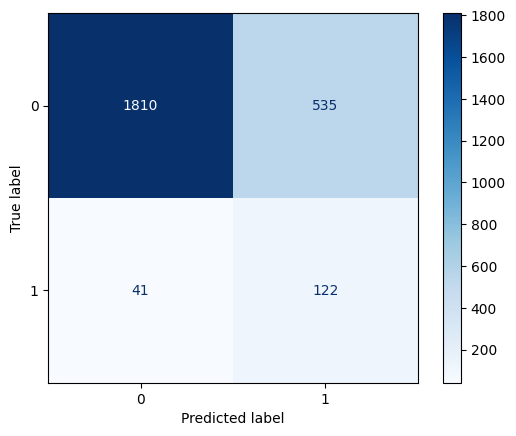

In [71]:
# Análisis final de errores

cm = confusion_matrix(y_test, y_pred_test_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

El modelo final consigue una excelente capacidad de detección (recall del 75%) sobre la clase minoritaria, con solo 41 impagos reales no detectados. Aunque el número de falsos positivos es elevado (535), esta configuración es aceptable según los requisitos del negocio, que priorizan no pasar por alto ningún posible cliente de riesgo. El balance logrado entre ambas clases se ajusta perfectamente al criterio de recall medio ≥ 50%, y el modelo demuestra un buen compromiso entre sensibilidad y estabilidad.